<a href="https://colab.research.google.com/github/Nashi8/118S/blob/main/Housing_Prices_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#data is from Zillow
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(io.StringIO(uploaded[file_name].decode('utf-8')))

# price comes in as object (may have $/commas). Coerce to numeric.
df['price'] = pd.to_numeric(
    df['price'].astype(str).str.replace(r'[^0-9.\-]', '', regex=True),
    errors='coerce'
)

# Ensure zipcode is string (not float) so OHE treats it as categorical
# If there are NaNs in zipcode, keep them as "<NA>" string so encoder can handle_unknown
df['zipcode'] = df['zipcode'].astype('Int64').astype(str)

# Drop any rows with missing essentials after cleaning (optional, but avoids fit/predict issues)
df = df.dropna(subset=['price', 'square_footage', 'zipcode'])

# --- Features & target ---
X = df[['square_footage', 'zipcode']]
y = df['price']

# --- One-hot encode zipcode; keep square_footage as-is ---
# Use sparse_output for sklearn >= 1.2, else fallback to sparse
try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('zipcode', ohe, ['zipcode'])
    ],
    remainder='passthrough'  # square_footage will be appended at the end
)

# --- Pipeline ---
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# --- Train/test split & train ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model.fit(X_train, y_train)

# --- Evaluate ---
r2 = model.score(X_test, y_test)
print(f"Test R^2: {r2:.4f}")

# --- Predict for a new house: 2000 sq ft in zipcode 94538 (exists in the CSV) ---
new_house = pd.DataFrame({'square_footage': [2000], 'zipcode': ['94538']})
predicted_price = model.predict(new_house)
print(f"Predicted price for a 2000 sq ft house in 94538: ${predicted_price[0]:,.2f}")

# --- Inspect learned coefficients ---
ohe_names = (model.named_steps['preprocessor']
                 .named_transformers_['zipcode']
                 .get_feature_names_out(['zipcode'])).tolist()
feature_names = ohe_names + ['square_footage']

coef = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

print("\nModel Coefficients:")
for fname, c in zip(feature_names, coef):
    print(f"{fname}: {c:.4f}")
print(f"Intercept: {intercept:.4f}")

Saving HousingPrices.csv to HousingPrices (8).csv
Test R^2: -16.3765
Predicted price for a 2000 sq ft house in 94538: $2,475,797.44

Model Coefficients:
zipcode_94536: 585615.4380
zipcode_94538: 95889.8444
zipcode_94560: -681505.2824
square_footage: 2114.9426
Intercept: -1849977.5774


Part 2

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sample customer churn dataset, data created by ChatGPT
data = {
    'age': [25, 45, 34, 29, 60, 40, 33, 52, 48, 27,
            36, 50, 42, 31, 55, 38, 44, 47, 28, 62],
    'monthly_usage': [120, 80, 100, 140, 60, 90, 110, 70, 75, 130,
                      105, 65, 85, 125, 55, 95, 88, 78, 135, 50],
    'purchase_amount': [200, 150, 180, 220, 100, 160, 190, 120, 140, 210,
                        175, 110, 155, 205, 95, 165, 145, 135, 215, 90],
    'customer_service_calls': [1, 4, 2, 1, 6, 3, 2, 5, 3, 1,
                               2, 4, 3, 1, 5, 2, 3, 4, 1, 6],
    'region': ['North', 'South', 'East', 'West', 'North',
               'South', 'East', 'West', 'North', 'South',
               'East', 'West', 'North', 'South', 'East',
               'West', 'North', 'South', 'East', 'West'],
    'churn': [0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
              0, 1, 1, 0, 1, 0, 1, 1, 0, 1]
}
df_churn = pd.DataFrame(data)
df_churn = df_churn.rename(columns={'monthly_usage': 'monthly_usage_hours'})

# Features and target
X = df_churn[['age', 'monthly_usage_hours', 'purchase_amount',
              'customer_service_calls', 'region']]
y = df_churn['churn']

# Preprocessing: Scale numeric, one-hot encode categorical
num_features = ['age', 'monthly_usage_hours', 'purchase_amount', 'customer_service_calls']
cat_features = ['region']

# Robust OHE across sklearn versions + ignore unknown categories
try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', ohe, cat_features)
    ],
    remainder='drop'
)

# Pipeline with logistic regression (add max_iter for convergence)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model.fit(X_train, y_train)

# Predict churn probability for a new customer
new_customer = pd.DataFrame({
    'age': [35],
    'monthly_usage_hours': [20],
    'purchase_amount': [150],
    'customer_service_calls': [5],
    'region': ['West']
})
churn_probability = model.predict_proba(new_customer)[0, 1]  # P(class=1)

# Classify based on threshold (0.5)
threshold = 0.5
churn_prediction = 1 if churn_probability >= threshold else 0

print(f"Churn Probability for new customer: {churn_probability:.2f}")
print(f"Churn Prediction (1 = churn, 0 = no churn): {churn_prediction}")

# Display model coefficients (match transformer order: numeric first, then categorical)
num_names = num_features
cat_names = (model.named_steps['preprocessor']
                  .named_transformers_['cat']
                  .get_feature_names_out(cat_features)).tolist()
feature_names = num_names + cat_names

coefficients = model.named_steps['classifier'].coef_[0]
print("\nModel Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

Churn Probability for new customer: 0.90
Churn Prediction (1 = churn, 0 = no churn): 1

Model Coefficients:
age: 0.7608
monthly_usage_hours: -0.6768
purchase_amount: -0.7283
customer_service_calls: 0.5578
region_East: -0.3743
region_North: 0.6742
region_South: -0.4271
region_West: 0.1244


Part 3

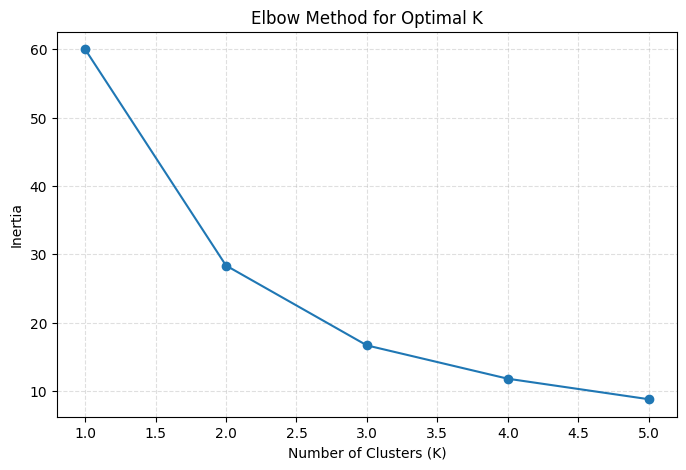

Cluster Characteristics:
         annual_spending  purchase_frequency    age
cluster                                            
0                 541.67                5.67  32.00
1                 545.00                6.00  51.33
2                1525.00               14.88  36.38

Cluster 0 Strategy:
Low-engagement customers: Send personalized re-engagement campaigns.

Cluster 1 Strategy:
Low-engagement customers: Send personalized re-engagement campaigns.

Cluster 2 Strategy:
High-spending customers: Offer exclusive promotions or loyalty rewards.

Saved: customer_segments.csv and elbow_plot.png


In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Sample customer data, data created by ChatGPT
data = {
    'annual_spending': [
        700, 1800, 250, 1450, 900, 300, 1100, 750, 1600, 550,
        1300, 400, 2000, 850, 450, 1700, 650, 220, 1250, 500
    ],
    'purchase_frequency': [
        7, 18, 2, 14, 9, 3, 11, 8, 16, 5,
        12, 4, 20, 10, 6, 15, 9, 2, 13, 5
    ],
    'age': [
        26, 38, 50, 30, 55, 40, 42, 28, 49, 35,
        33, 47, 29, 52, 36, 31, 44, 60, 39, 27
    ],
    'region': [
        'East', 'North', 'South', 'West', 'East',
        'South', 'North', 'West', 'South', 'East',
        'North', 'South', 'West', 'East', 'South',
        'North', 'West', 'South', 'East', 'North'
    ]
}
df = pd.DataFrame(data)

# Preprocess data: Select numerical features and scale them
features = ['annual_spending', 'purchase_frequency', 'age']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using elbow method
inertia = []
K = range(1, 6)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(list(K), inertia, 'o-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()
plt.savefig('elbow_plot.png')
plt.close()

# Apply K-Means with optimal K (e.g., 3 based on elbow method)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = df.groupby('cluster')[features].mean().round(2)
print("Cluster Characteristics:")
print(cluster_summary)

# Example of targeted strategies (indent inside the loop!)
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} Strategy:")
    if cluster_summary.loc[cluster, 'annual_spending'] > 1000:
        print("High-spending customers: Offer exclusive promotions or loyalty rewards.")
    elif cluster_summary.loc[cluster, 'purchase_frequency'] > 10:
        print("Frequent buyers: Provide bulk discounts or subscription plans.")
    else:
        print("Low-engagement customers: Send personalized re-engagement campaigns.")

# Save cluster assignments to CSV
df.to_csv('customer_segments.csv', index=False)
print("\nSaved: customer_segments.csv and elbow_plot.png")

Extra Credit

Evaluation on last 3 months:
MAE: 7.76, R²: -0.603


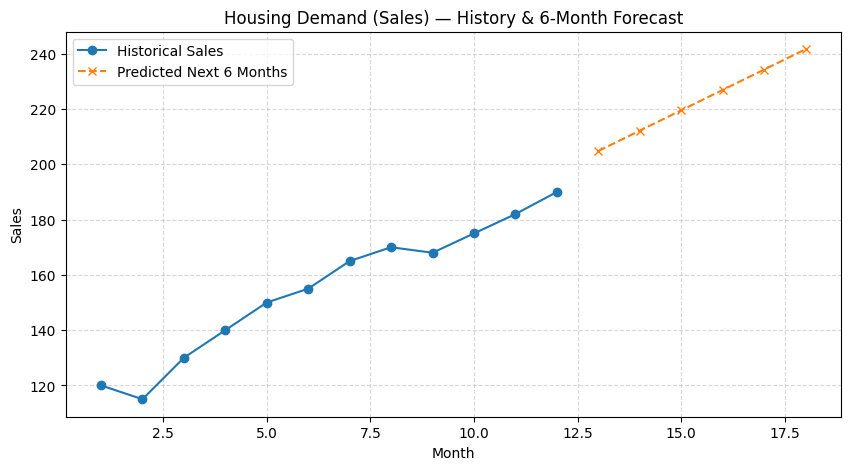

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1) Sample dataset, data created by ChatGPT

data = {
    'month': list(range(1, 13)),  # months 1-12
    'sales': [120, 115, 130, 140, 150, 155,
              165, 170, 168, 175, 182, 190]  # made-up sales figures
}
df = pd.DataFrame(data)

# 2) Train/test split (hold out last 3 months for evaluation)

X = df[['month']]
y = df['sales']

X_train, y_train = X.iloc[:-3], y.iloc[:-3]
X_test, y_test = X.iloc[-3:], y.iloc[-3:]

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate on the holdout
y_pred_test = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Evaluation on last 3 months:")
print(f"MAE: {mae:.2f}, R²: {r2:.3f}")

# 3) Forecast next 6 months
last_month = df['month'].max()
future_months = pd.DataFrame({'month': range(last_month + 1, last_month + 7)})
future_preds = model.predict(future_months)

# 4) Plot historical + forecast
plt.figure(figsize=(10, 5))
plt.plot(df['month'], y, label='Historical Sales', marker='o')
plt.plot(future_months['month'], future_preds,
         label='Predicted Next 6 Months', linestyle='--', marker='x')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Housing Demand (Sales) — History & 6-Month Forecast')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Assumptions
- Housing sales can be approximated by a simple linear relationship with time (month).
- The dataset is small and synthetic (12 months), so the results are illustrative only.
-No explicit seasonality (e.g., summer spikes in demand) or external factors (e.g., interest rates, economic conditions) are included.

Challenges
- Limited data points restrict the model’s ability to generalize or capture complex trends.
- Real housing markets often show seasonal and cyclical behavior that a simple linear regression cannot model.
- Real-world data can contain missing values, outliers, and structural breaks that complicate forecasting.

Potential Improvements
- Collect and use a longer historical dataset to train a more robust model.
- Add seasonality features such as month-of-year or use cyclical encodings to capture recurring patterns.
- Explore more advanced time-series forecasting methods such as ARIMA, SARIMA, or Prophet.
- Incorporate external drivers (inventory levels, housing prices, mortgage/interest rates, marketing activity) to improve predictive power.